# Field Goals

In 2013, in the paper Going For Three, the authors undertook predictive modelling of field goal success in the NFL from 2000 to 2011. The study found that several psychological factors had little to no effect on the likelihood of field goal conversion. In 2018, in the paper Choking Under the Pressure, the authors extended the aforementioned study to include data post-2011, up to and including 2017. They found that some of the psychological factors were in fact significant at the 0.1 level.

Neither study looked into the possibility of interactions between the supposedly (independent) variables, which may dilute the observed main effects or even show the effect to be significant. For example, one may reasonably expect that the effect of wind on a kick would increase with distance. Futhermore, in 2015, a rule change saw the extra point distance increased from 20 yards to 33. 20 yard extra point kicks historically average around 99% conversion. The 13 yard increase resulted in a 6% point drop the year of its inception, which continues to this day. As such, we will model only field goals up until 2015, at which time we will then include extra point kicks.

Both studies took a frequentist statistical approach, which although provide frequency guarantees with regards to confidence intervals etc, accept and reject significance of variables at arbitrarly decided values of 0.05 and 0.1. Within Bayesian statistics, by framing parameters as random variables, we are able to give likelihoods of each variable being within some range (credible interval). Arguably more intuitive than the frequentist confidence interval. For small sample sizes, we do forgo some of the frequentist guarantees of confidence intervals, but these concerns disappear for larger samples as the two methods converge asymptotically. With this in mind, we will be using a frequentist approach until the 2015 rule change. The results of this period of time will be used as priors to a Bayesian statistical model which will handle post-rule change data.

This notebook will include exploring the data, validating the results of the earlier papers, and exploring the possibility of interactions. With the most influential interactions, we will use a frequentist approach to the pre-2015 data, and see how our results differ from Going For Three. In the next notebook, we will incorporate these results into the prior distributions for the independent variables and train a model on post-2015 data using MCMC.

## Imports

In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import glm as glm_sm
import numpy as np
import mysql.connector
import itertools
import dtale
from scipy.stats import chi2, pointbiserialr, pearsonr
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt


import sys
sys.path.append('..')
from util.metrics import tetrachoric
from util.graphics.factorplots import interaction_plot
from scripts.train import get_data
from util.summary import Summary

## Load Data

Set up a connection to the mysql database served locally.

In [2]:
cnx = mysql.connector.connect(user='root', password='mOntie20!mysql', host='127.0.0.1', database='nfl')

We shall first load all the data and inspect it with the d-tale tool or similar pandas functions.

In [3]:
df = get_data(cnx, '<= 2019').drop('fkicker', axis=1)

# dtale.show(df)
print(len(df), 'rows.')
df.head(10)

19715 rows.


,good,dist,year,seasons,cold,altitude,humid,windy,away_game,postseason,iced,turf,precipitation,pressure
pid,,,,,,,,,,,,,,
17,1,43,2000,19,0,0,0,0,0,0,0,1,0,0
34,1,44,2000,19,0,0,0,0,0,0,0,1,0,0
52,1,24,2000,19,0,0,0,0,0,0,0,1,0,0
64,1,44,2000,19,0,0,0,0,0,0,0,1,0,0
95,1,48,2000,19,0,0,0,0,0,0,0,1,0,0
241,1,50,2000,6,0,0,1,0,1,0,1,0,0,0
277,1,25,2000,6,0,0,1,0,1,0,0,0,0,0
375,1,33,2000,3,0,0,0,0,1,0,0,1,0,0
387,1,34,2000,1,0,0,0,0,0,0,0,1,0,0


We assess the correlations: continuous pairs with Pearsons, continuous-binary with pointbiserial, binary pairs with tetrachoric.

In [4]:
bin_vars = df.drop(['dist','year','seasons'], axis=1).columns.values
con_vars = ['dist','year','seasons']
correlations = []

for v1, v2 in itertools.product(bin_vars,bin_vars):
    if v1>v2:
        try:
            correlations.append([v1,v2,tetrachoric(df[v1],df[v2]),None,'tetrachoric'])
        except Exception as e:
            print(e)
            print(f'{v1}-{v2}: NaN')

for b1, c2 in itertools.product(bin_vars,con_vars):
    try:
        correlations.append([b1, c2, pointbiserialr(df[b1],df[c2])[0], pointbiserialr(df[b1],df[c2])[1], 'pointbiserial'])
    except Exception as e:
        print(e)
        print(f'{b1}-{c2}: {e}')

for c1, c2 in itertools.product(con_vars,con_vars):
    if c1>c2:
        try:
            correlations.append([c1, c2, pearsonr(df[c1],df[c2])[0], pearsonr(df[c1],df[c2])[1], 'pearsons'])
        except Exception as e:
           print(f'{c1}-{c2}: {e}')


df_corr = pd.DataFrame.from_records(correlations, columns=['cov 1','cov 2', 'corr', 'p','type'])

In [5]:
df_corr[abs(df_corr['corr'])>0.2].sort_values('corr')

,cov 1,cov 2,corr,p,type
33,turf,altitude,-1.000000,NaN,tetrachoric
7,humid,altitude,-0.493396,NaN,tetrachoric
42,precipitation,altitude,-0.439046,NaN,tetrachoric
55,good,dist,-0.340700,0.0,pointbiserial
11,windy,altitude,-0.296094,NaN,tetrachoric
34,turf,humid,-0.272831,NaN,tetrachoric
16,windy,turf,-0.256228,NaN,tetrachoric
45,precipitation,postseason,0.208665,NaN,tetrachoric
12,windy,humid,0.234350,NaN,tetrachoric
22,postseason,altitude,0.245919,NaN,tetrachoric



From the table above we can see a few things.
* The strongest correlations belong to the binary variables
* turf and altitude have a strong correlation because there is only one stadium at altitude, Denver, and that stadium has a grass surface.
* Weather conditions are relatively strongly correlated to altitude. Which is a well known in meteorology.
* Precipitation increases humidity, that should be obvious.
* Postseason games take place in the winter, so are usually played in cold weather.
* Coaches tend to ice kickers when the game is tight, i.e. pressure situations.

Just to check the continuous variables for non-linear correlations, i'm going to plot them on a scatter matrix.

In [6]:
# scatter_matrix(df.drop(bin_vars, axis=1), figsize=(15,15))

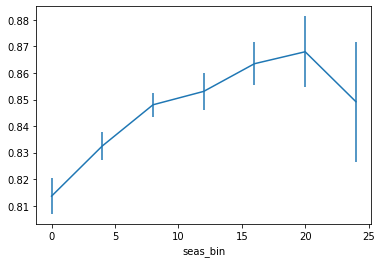

In [7]:
df['seas_bin'] = 4*round(df['seasons']/4)
means = df.groupby('seas_bin')['good'].mean()
errors = np.sqrt(means*(1-means)/df.groupby('seas_bin')['good'].size())
means.plot(yerr=errors)
plt.show()

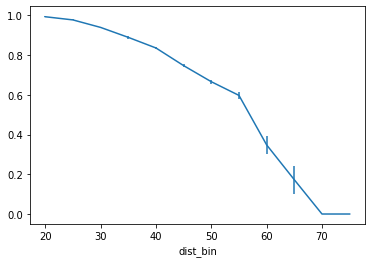

In [8]:
df['dist_bin'] = 5*round(df['dist']/5)
means = df.groupby('dist_bin')['good'].mean()
errors = np.sqrt(means*(1-means)/df.groupby('dist_bin')['good'].size())
means.plot(yerr=errors)
plt.show()

Not much we can pull from the above scatters, but lets make a few points.
* It looks like as kickers get late into their careers, they take fewer long distance attempts.
* Distance of attempts for each year is relatively stable. Looks like 2008 has a few massively long attempts.
* Seasons only increasings year-on-year because the span isnt long enough to record retirements. So moving on, we'd expect less correlation.
* Good vs seasons looks non-linear, but the error bars on very experienced kickers are large. Possibly a need for a quadratic term.

## Reproduction

In this section we are going to try reproduce the results from the 2 papers mentioned, Going For Three and Choking Under the Pressure. We won't be addressing interaction and multicollinearity just yet, we leave this for the next section.

### Going For Three

Query the database for the data used by Going For Three. i.e. pre-2011.
Going For Three didn't use the year and seasons variables in their tabulated results, so our first model won't either.

In [9]:
df_gft = get_data(cnx, '<= 2011').drop(['seasons','year','fkicker'], axis=1)
print(len(df_gft))
df_gft.head(10)

11605


,good,dist,cold,altitude,humid,windy,away_game,postseason,iced,turf,precipitation,pressure
pid,,,,,,,,,,,,
17,1,43,0,0,0,0,0,0,0,1,0,0
34,1,44,0,0,0,0,0,0,0,1,0,0
52,1,24,0,0,0,0,0,0,0,1,0,0
64,1,44,0,0,0,0,0,0,0,1,0,0
95,1,48,0,0,0,0,0,0,0,1,0,0
241,1,50,0,0,1,0,1,0,1,0,0,0
277,1,25,0,0,1,0,1,0,0,0,0,0
375,1,33,0,0,0,0,1,0,0,1,0,0
387,1,34,0,0,0,0,0,0,0,1,0,0


In [10]:
model = glm_sm('good ~ ' + '+'.join(df_gft.drop('good', axis=1).columns.values), df_gft, family=sm.families.Binomial())
result = model.fit(method='newton')
print(result.summary())
base_ll = pd.read_html(result.summary().tables[0].as_html())[0].iloc[4,3]

Generalized Linear Model Regression Results                  
Dep. Variable:                   good   No. Observations:                11605
Model:                            GLM   Df Residuals:                    11593
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                        newton   Log-Likelihood:                -4511.0
Date:                Fri, 28 Feb 2020   Deviance:                       9021.9
Time:                        08:16:30   Pearson chi2:                 1.09e+04
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.1404      0.149     41.085      0.000      

We now add back in the year and seasons of experience and control for kickers that dont make it in the NFL (so >=50 kicks overall or >=3 seasons at the time of kick). Notice this is a little different from the Going For Three paper. Their criteria threw out a few valid datapoints from experienced kickers at the start and end of the dataset.

In [11]:
where = '''\nand (
(
    fg.fkicker in (select fkicker from fifty) -- has had at least 50 attempts overall (this keeps only kickers that would end up making it in the NFL)
) or    
(
    k.seas>=3  -- or they had played 3 seasons up to the kick (stops removal of kicks from experienced kickers' kicks from early or late in the dataset)
)
)'''

df_gft_ext = get_data(cnx, '<= 2011', where).drop('fkicker', axis=1)
print(len(df_gft_ext), 'valid kicks.')
df_gft_ext.head(5)

11284 valid kicks.


,good,dist,year,seasons,cold,altitude,humid,windy,away_game,postseason,iced,turf,precipitation,pressure
pid,,,,,,,,,,,,,,
17,1,43,2000,19,0,0,0,0,0,0,0,1,0,0
34,1,44,2000,19,0,0,0,0,0,0,0,1,0,0
52,1,24,2000,19,0,0,0,0,0,0,0,1,0,0
64,1,44,2000,19,0,0,0,0,0,0,0,1,0,0
95,1,48,2000,19,0,0,0,0,0,0,0,1,0,0


In [12]:
model = glm_sm('good ~ '+'+'.join(df_gft_ext.drop('good', axis=1).columns.values), df_gft_ext, family=sm.families.Binomial())
result = model.fit(method='newton')
print(result.summary())

Generalized Linear Model Regression Results                  
Dep. Variable:                   good   No. Observations:                11284
Model:                            GLM   Df Residuals:                    11270
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                        newton   Log-Likelihood:                -4302.8
Date:                Fri, 28 Feb 2020   Deviance:                       8605.7
Time:                        08:16:32   Pearson chi2:                 1.06e+04
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -69.8707     16.103     -4.339      0.000    -1

Again, we see that we've arrived at similar results. The psychological variables seem less influential than the environmental and physical factors.

### Choking Under the Pressure

In Choking Under the Pressure, they used similar data now from 2000-2017.
Lets repeat the modelling with this data, again leaving out the seasons and year covariates and not controlling for >50 kicks

In [13]:
df_cup = get_data(cnx, '<= 2017').drop(['seasons','year','fkicker'], axis=1)
print(len(df_cup),'valid kicks.')
df_cup.head(5)

17738 valid kicks.


,good,dist,cold,altitude,humid,windy,away_game,postseason,iced,turf,precipitation,pressure
pid,,,,,,,,,,,,
17,1,43,0,0,0,0,0,0,0,1,0,0
34,1,44,0,0,0,0,0,0,0,1,0,0
52,1,24,0,0,0,0,0,0,0,1,0,0
64,1,44,0,0,0,0,0,0,0,1,0,0
95,1,48,0,0,0,0,0,0,0,1,0,0


In [14]:
model = glm_sm('good ~ '+'+'.join(df_cup.drop(['good'], axis=1).columns.values), df_cup, family=sm.families.Binomial())
result = model.fit(method='newton')
print(result.summary())

Generalized Linear Model Regression Results                  
Dep. Variable:                   good   No. Observations:                17738
Model:                            GLM   Df Residuals:                    17726
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                        newton   Log-Likelihood:                -6619.4
Date:                Fri, 28 Feb 2020   Deviance:                       13239.
Time:                        08:16:34   Pearson chi2:                 1.67e+04
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.1719      0.124     49.787      0.000      

Again we see similar results. Icing is significant at the 0.1 level as per the paper.

## Regression Analysis & Expanding the Model

From now on we'll be using data from before the extra point rule change (pre-2015). Pre-2015/16, the XP distance was 20 yards with 98-99% conversion. In 2015/16, it was changed to 33 yards, and conversion percentage clearly dropped. So we will include data up until then and then perform our bayesian analysis post-2015.

In [15]:
query = '''select g.seas, avg(f.good) from fgxp f join play p on f.pid=p.pid join game g on g.gid=p.gid where f.fgxp='xp' group by g.seas'''
df_xp = pd.read_sql(query,cnx)
df_xp

,seas,avg(f.good)
0,2000,0.9909
1,2001,0.9804
2,2002,0.9821
3,2003,0.9830
4,2004,0.9904
5,2005,0.9845
6,2006,0.9882
7,2007,0.9863
8,2008,0.9902
9,2009,0.9824


### 2-cat for 6-cat Pressure

The Going For Three paper used a binary pressure variable. The authors said there was little difference in the results when using a 6 level ordinal variable, but regardless, I'd like to check it's influence on the pre-2015 data. Artificial dichotomy of variables can impart bias (so, too, would the 6-cat variable for that matter), and even if the pressure variable is largely insignificant, it makes more sense to differentiate a 4th qtr, 7 point deficit FG from an overtime winner.

In [16]:
where = '''and (
(
    fg.fkicker in (select fkicker from fifty) -- has had at least 50 attempts overall (this keeps only kickers that would end up making it in the NFL)
) or    
(
    k.seas>=3  -- or they had played 3 seasons up to the kick (stops removal of kicks from experienced kickers' kicks from early or late in the dataset)
)
)'''

In [17]:
# 2 cat result
df = get_data(cnx, date_condition='< 2015', where=where, base='base_query')
formula = 'good ~ ' + '+'.join(df.drop(['good','fkicker'], axis=1).columns.values)
model = glm_sm(formula, df, family=sm.families.Binomial())
result = model.fit(method='irls')
print('BIC: ',result.bic, 'AIC: ', result.aic)
with_ = Summary(result)
print(with_)

#6 cat
df = get_data(cnx, date_condition='< 2015', where=where, base='six_cat')
formula = 'good ~ ' + '+'.join(df.drop(['good','fkicker'], axis=1).columns.values)
model = glm_sm(formula, df, family=sm.families.Binomial())
result = model.fit(method='irls')
print('BIC: ',result.bic, 'AIC: ', result.aic)
without_ = Summary(result)
print(without_)



BIC:  -126089.20370236412 AIC:  10616.888961759592
                 Generalized Linear Model Regression Results                  
Dep. Variable:                   good   No. Observations:                14299
Model:                            GLM   Df Residuals:                    14285
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5294.4
Date:                Fri, 28 Feb 2020   Deviance:                       10589.
Time:                        08:16:38   Pearson chi2:                 1.35e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

There's very little difference, but pressure seems to become more significant, as does icing. This may indicate the predictive power is more or less the same but the quality of inference may be improved by using a 6-category pressure system.

### Multicollinearity

Neither of the aforementioned papers addressed the possibility of multicollinearity, omitted variable bias, and interactions. We shall check the former here.

In the LR section, we remove each of the variables one-by-one and assess the changes in expected values and standard errors of coefficients of the remaining variables. Multicollinearity affects the standard errors of correlated variables and reduces stability when present. However, if a variable is correlated to both the dependent and an independent variable but is omitted, the remaining correlated variable exhibits bias (omitted variable bias or OVB).

In the LASSO section, we perform regularised regression on the normalized data and see which variables have non-zero coefficients.

#### Likelihood Ratio Test

We can tabulate the results, showing the change in expected coefficients and std errs when we include/exclude each covariate. A summary of the findings is presented below.

In [122]:
df = get_data(cnx, date_condition='< 2015', where=where, base='six_cat')

In [19]:
# base result
formula = 'good ~ ' + '+'.join(df.drop(['good','fkicker'], axis=1).columns.values)
model = glm_sm(formula, df, family=sm.families.Binomial())
result = model.fit(method='irls')
with_ = Summary(result)
print(with_)

Generalized Linear Model Regression Results                  
Dep. Variable:                   good   No. Observations:                14299
Model:                            GLM   Df Residuals:                    14285
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5294.1
Date:                Fri, 28 Feb 2020   Deviance:                       10588.
Time:                        08:16:43   Pearson chi2:                 1.35e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -93.9637     11.649     -8.066      0.000    -1

In [20]:
# removing covariates
removed = {}

for cov in df.drop(['good','fkicker'], axis=1).columns.values:
    formula = 'good ~ ' + '+'.join(df.drop(['good','fkicker',cov], axis=1).columns.values)
    model = glm_sm(formula, df, family=sm.families.Binomial())
    without_ = Summary(model.fit(method='irls'))
    difference, p = with_ - without_
    removed[cov] = {'diff':difference, 'p': p, 'summary': without_}

In [21]:
print('LR test p-values:\n', [(cov,round(d['p'],4)) for cov,d in removed.items()])

LR test p-values:
 [('dist', 0.0), ('year', 0.0), ('seasons', 0.0047), ('cold', 0.0), ('altitude', 0.0008), ('humid', 1.0), ('windy', 0.0034), ('away_game', 1.0), ('postseason', 0.138), ('iced', 0.0736), ('turf', 0.0), ('precipitation', 0.032), ('pressure', 0.3711)]


In [22]:
cov = 'year'
print(f'Results for "{cov}""\n', 'P(LR|Ho): ', removed[cov]['p'])
removed[cov]['diff']

Results for "year""
 P(LR|Ho):  6.378900535848336e-18


,coef with_year,coef w/o_year,% coef,se with_year,se w/o_year,% se,P with_year,P w/o_year
Intercept,-93.9637,6.0754,106.465688,11.649,0.147,98.738089,0.000,0.000
altitude,0.4820,0.4825,-0.103734,0.148,0.148,0.000000,0.001,0.001
away_game,-0.0129,-0.0115,10.852713,0.049,0.049,0.000000,0.794,0.814
cold,-0.3764,-0.3825,-1.620616,0.058,0.058,0.000000,0.000,0.000
dist,-0.1150,-0.1126,2.086957,0.003,0.003,0.000000,0.000,0.000
humid,-0.0081,-0.0292,-260.493827,0.055,0.055,0.000000,0.883,0.595
iced,-0.1349,-0.1296,3.928836,0.074,0.073,1.351351,0.067,0.077
postseason,-0.1836,-0.1976,-7.625272,0.121,0.121,0.000000,0.130,0.102
precipitation,-0.1881,-0.2324,-23.551302,0.087,0.087,0.000000,0.031,0.007
pressure,0.0210,0.0185,11.904762,0.024,0.024,0.000000,0.383,0.440


* dist: OVB on iced and also goes siginificant, OVB with pressure but not significant anyway, maybe OVB with away_game but never significant. LR test rejected null.
* altitude: Sigificant on its own, no real OVB seen elsewhere, apart from humid which wasnt significant anyway. LR test rejected null.
* away_game: No OVB and not siginificant to begin with. LR test did not reject null.
* cold: OVB on postseason (which also became significant w/o cold). Slight OVB with windy. LR test rejected null.
* humid: No change on any covariate estimates. LR test did not reject null.
* iced: OVB on pressure but it never became significant. LR test did not reject null, however it was close.
* postseason: Nothing. LR test did not reject null.
* precipitation: OVB on humidity (theyre correlated), but no changes on significance. LR test rejected null.
* pressure: No change. Not even an OVB on iced. LR test did not reject null.
* seasons: No change. Is significant variable. LR test rejected null.
* turf: OVB on humidity, turf pitches must be in warmer climates. LR test rejected null.
* windy: No change. LR test rejected null.
* year: No change. Slight OVB on seasons as we didnt see too many retirements for 2000-2015. LR test rejected null.

Points:
* cold vs postseason -- postseason is in winter so removing cold resulting in strong OVB on postseason estimate.
* dist vs iced -- Dist is a strong indicator, and iced kicks are slightly longer on average, hence the OVB.
* standard errors not largely different from control to treatment, but OVB seems significant for a few combinations.
* Humidity adds nothing and we see no OVB with its omissions. We'll remove it.


In this many LR tests, we're almost certainly going to get a false positive.
We can also perform a LASSO regression on the (normalised) data, then look at the non-zero coefficients.

#### LASSO

Regularisation enforces sparsity. So assuming our variables are on the same scale, the largest absolute coefficients should indicate the most important variables.

In [130]:
# we scale the non-binary variables to be between 0 and 1.
normed = df.copy().drop(['fkicker'], axis=1)
normed['dist'] = (normed['dist']-normed['dist'].min())/(normed['dist'].max()-normed['dist'].min())
normed['year'] = (normed['year']-normed['year'].min())/(normed['year'].max()-normed['year'].min())
normed['seasons'] = (normed['seasons']-normed['seasons'].min())/(normed['seasons'].max()-normed['seasons'].min())
normed.head()

,good,dist,year,seasons,cold,altitude,humid,windy,away_game,postseason,iced,turf,precipitation,pressure
pid,,,,,,,,,,,,,,
17,1,0.431034,0.0,0.72,0,0,0,0,0,0,0,1,0,1
34,1,0.448276,0.0,0.72,0,0,0,0,0,0,0,1,0,1
52,1,0.103448,0.0,0.72,0,0,0,0,0,0,0,1,0,1
64,1,0.448276,0.0,0.72,0,0,0,0,0,0,0,1,0,1
95,1,0.517241,0.0,0.72,0,0,0,0,0,0,0,1,0,1


In [131]:
from sklearn.linear_model import LogisticRegression
    
model = LogisticRegression(penalty='l1', max_iter=5000, solver='liblinear')
model.fit(X=normed.drop('good', axis=1), y=normed['good'])
lasso_results = pd.Series(index=normed.drop('good', axis=1).columns.values,data=model.coef_[0]).abs().sort_values(ascending=False)
lasso_results[lasso_results>0]

dist             6.618707
year             0.695022
altitude         0.458365
cold             0.371647
seasons          0.340966
turf             0.234855
precipitation    0.182330
postseason       0.168458
windy            0.157999
iced             0.130143
pressure         0.020543
away_game        0.009277
humid            0.007123
dtype: float64

Clearly distance is the biggest factor, followed by year, altitude, cold, seasons, surface and precipitation. Psychological factors like postseason, iced, pressure, and away_game are less important. Humidity, as was the case in the LR test, is the least important.

### Iteractions

Now lets look at some interactions of the covariates and see if any of those are important. We first take a graphical approach, using interaction plots with standard error bars to assess interactions we think are reasonably likely to be significant and not spurious. We also perform a likelihood ratio test for each interaction.

In [87]:
df = get_data(cnx, date_condition='< 2015', where=where, base='six_cat').drop('humid', axis=1)

In [24]:
# base result
formula = 'good ~ ' + '+'.join(df.drop(['good','fkicker'], axis=1).columns.values)
model = glm_sm(formula, df, family=sm.families.Binomial())
result = model.fit(method='irls')
without_ = Summary(result)
print(without_)

Generalized Linear Model Regression Results                  
Dep. Variable:                   good   No. Observations:                14299
Model:                            GLM   Df Residuals:                    14286
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5294.1
Date:                Fri, 28 Feb 2020   Deviance:                       10588.
Time:                        08:16:48   Pearson chi2:                 1.35e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -94.0453     11.636     -8.082      0.000    -1

In [142]:
def get_interactions(covariates, triples=False):
    interactions = []
    for i,j in itertools.product(covariates,covariates):
        if i>j:
            interactions.append(i+'*'+j)

    if triples:
        for i,j,k in itertools.product(covariates,covariates, covariates):
            if i>j>k:
                interactions.append(i+'*'+j+'*'+k)

    return interactions

In [147]:
covariates = df.drop(['good','fkicker'], axis=1).columns.values
interactions = get_interactions(covariates, triples=False)

#### LASSO
Performing LASSO is one way of finding the most important variables and their interactions. We'll create variables for all the interactions, then bootstrap several times and find the coefficients of the penalised LR model each time.

In [152]:
# we scale the non-binary variables to be between 0 and 1 so we can see relative effects.
normed = df.copy().drop(['fkicker'], axis=1)
normed['dist'] = (normed['dist']-normed['dist'].min())/(normed['dist'].max()-normed['dist'].min())
normed['year'] = (normed['year']-normed['year'].min())/(normed['year'].max()-normed['year'].min())
normed['seasons'] = (normed['seasons']-normed['seasons'].min())/(normed['seasons'].max()-normed['seasons'].min())
normed.head()

,good,dist,year,seasons,cold,altitude,humid,windy,away_game,postseason,iced,turf,precipitation,pressure
pid,,,,,,,,,,,,,,
17,1,0.431034,0.0,0.72,0,0,0,0,0,0,0,1,0,1
34,1,0.448276,0.0,0.72,0,0,0,0,0,0,0,1,0,1
52,1,0.103448,0.0,0.72,0,0,0,0,0,0,0,1,0,1
64,1,0.448276,0.0,0.72,0,0,0,0,0,0,0,1,0,1
95,1,0.517241,0.0,0.72,0,0,0,0,0,0,0,1,0,1


In [153]:
for interaction in interactions:
    covs = interaction.split('*')
    if len(covs) == 2:
        normed[interaction] = normed[covs[0]]*normed[covs[1]]
    else:
        normed[interaction] = normed[covs[0]]*normed[covs[1]]*normed[covs[2]]
normed.head()

,good,dist,year,seasons,cold,altitude,humid,windy,away_game,postseason,...,precipitation*postseason,precipitation*iced,pressure*dist,pressure*cold,pressure*altitude,pressure*humid,pressure*away_game,pressure*postseason,pressure*iced,pressure*precipitation
pid,,,,,,,,,,,,,,,,,,,,,
17,1,0.431034,0.0,0.72,0,0,0,0,0,0,...,0,0,0.431034,0,0,0,0,0,0,0
34,1,0.448276,0.0,0.72,0,0,0,0,0,0,...,0,0,0.448276,0,0,0,0,0,0,0
52,1,0.103448,0.0,0.72,0,0,0,0,0,0,...,0,0,0.103448,0,0,0,0,0,0,0
64,1,0.448276,0.0,0.72,0,0,0,0,0,0,...,0,0,0.448276,0,0,0,0,0,0,0
95,1,0.517241,0.0,0.72,0,0,0,0,0,0,...,0,0,0.517241,0,0,0,0,0,0,0


In [179]:
from sklearn.linear_model import LogisticRegression

coefs = {}
for i in range(30): # bootstrap for CI on coefficients
    boot = normed.sample(frac=1, replace=True)
    model = LogisticRegression(penalty='l1', max_iter=5000, solver='liblinear')
    model.fit(X=boot.drop('good', axis=1), y=boot['good'])
    coefs[i] = pd.Series(index=boot.drop('good', axis=1).columns.values,data=model.coef_[0])
df_boot = pd.DataFrame.from_dict(coefs, orient='columns')

In [182]:
df_coefs = pd.DataFrame.from_dict({'mean':df_boot.mean(axis=1), 'abs_mean':df_boot.mean(axis=1).abs(), 'std':df_boot.std(axis=1), '90left':df_boot.mean(axis=1)-1.64*df_boot.std(axis=1), '90right':df_boot.mean(axis=1)+1.64*df_boot.std(axis=1), 'contains 0':((df_boot.mean(axis=1)-1.64*df_boot.std(axis=1))<0) & ((df_boot.mean(axis=1)+1.64*df_boot.std(axis=1))>0)}, orient='columns').sort_values('abs_mean', ascending=False)
df_coefs[~df_coefs['contains 0'] & df_coefs['mean']>0]

,mean,abs_mean,std,90left,90right,contains 0
dist,-6.441039,6.441039,0.377888,-7.060775,-5.821302,False
year,0.851045,0.851045,0.229896,0.474015,1.228074,False
pressure*altitude,0.532569,0.532569,0.219953,0.171845,0.893293,False
seasons*away_game,-0.464140,0.464140,0.238096,-0.854618,-0.073662,False
iced*away_game,0.297466,0.297466,0.137603,0.071796,0.523135,False
windy*cold,-0.226399,0.226399,0.118674,-0.421024,-0.031773,False
humid*cold,-0.174878,0.174878,0.104096,-0.345596,-0.004161,False
windy*pressure,0.108469,0.108469,0.048558,0.028833,0.188104,False


Pressure\*altitude is almost certainly spurious. Seasons\*away_game is a strange one but domain knowledge says its not real. Iced\*away_game makes sense. As does windy\*cold. Humid\*cold is probably a proxy for precipitation\*cold. Windy\*pressure doesn't make sense.

So from LASSO:
* iced\*away_game
* windy\*cold

#### Likelihood Ratio Test

We expect to get a whole heap of false positives because we're doing a LOT of hypothesis tests, but regardless lets have a look at the LR test results for each interaction.

In [25]:
inters = {}
for interaction in interactions:
    formula = 'good ~ ' + '+'.join(covariates) + '+' + interaction

    model = glm_sm(formula, df, family=sm.families.Binomial())
    with_ = Summary(model.fit(method='irls'))
    diff, p = with_ - without_
    inters[interaction] = [interaction, with_.log_likelihood - without_.log_likelihood, p, diff]

df_inter = pd.DataFrame.from_records(list(inters.values()), columns=['interaction','delta_ll','p', 'diff']).set_index('interaction')

In [26]:
df_inter[df_inter['p']<0.4].sort_values('p', ascending=True).loc[:,['delta_ll','p']]

,delta_ll,p
interaction,,
pressure*altitude,4.9,0.001745
seasons*away_game,3.1,0.012775
seasons*dist,2.3,0.031972
iced*altitude,2.0,0.045500
windy*cold,1.9,0.051253
iced*away_game,1.8,0.057780
precipitation*altitude,1.4,0.094264
seasons*iced,1.3,0.106864
iced*cold,1.2,0.121335


Pressure\*altitude shows up again. Seasons\*dist is plausible. Windy\*postseason seems like an interaction by proxy (with cold). Seasons\*away_game shows up again. Iced*altitude is spurious. Windy\*cold is plausible. Iced\*away_game is plausible. Precipitation\*dist is plausible. Iced\*cold is plausible.

We're going to investigate windy\*cold, postseason\*away_game, postseason\*iced, iced\*away_game, pressure\*iced, iced\*cold, pressure\*postseason, pressure\*dist, seasons\*dist, seasons\*away_game, Precipitation\*dist and a possible complex windy\*dist interaction.

#### Cold & Windy

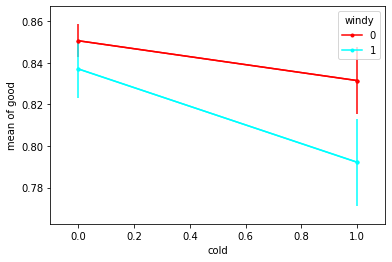

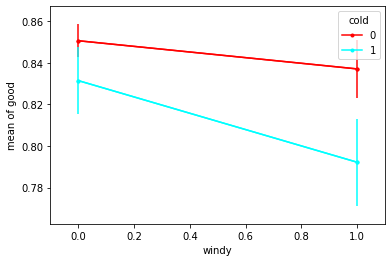

In [27]:
fig = interaction_plot(x=df['cold'].values,trace=df['windy'].values,response=df['good'].values, xlabel='cold', legendtitle='windy', ylabel='good', errorbars=True)
plt.show()

fig = interaction_plot(x=df['windy'].values,trace=df['cold'].values,response=df['good'].values, xlabel='windy', legendtitle='cold', ylabel='good', errorbars=True)
plt.show()

In [28]:
print('P(LR|Ho): ',df_inter.loc['windy*cold', 'p'])
df_inter.loc['windy*cold','diff']

P(LR|Ho):  0.05125258285733592


,coef with_windy:cold,coef w/o_windy:cold,% coef,se with_windy:cold,se w/o_windy:cold,% se,P with_windy:cold,P w/o_windy:cold
Intercept,-93.6400,-94.0453,-0.432828,11.641,11.636,0.042952,0.000,0.000
altitude,0.4750,0.4842,-1.936842,0.148,0.148,0.000000,0.001,0.001
away_game,-0.0149,-0.0128,14.093960,0.049,0.049,0.000000,0.763,0.795
cold,-0.2905,-0.3778,-30.051635,0.073,0.057,21.917808,0.000,0.000
dist,-0.1151,-0.1150,0.086881,0.003,0.003,0.000000,0.000,0.000
iced,-0.1332,-0.1348,-1.201201,0.074,0.074,0.000000,0.070,0.067
postseason,-0.1737,-0.1832,-5.469200,0.121,0.121,0.000000,0.153,0.131
precipitation,-0.1963,-0.1913,2.547122,0.085,0.084,1.176471,0.020,0.024
pressure,0.0221,0.0210,4.977376,0.024,0.024,0.000000,0.360,0.382
seasons,0.0143,0.0140,2.097902,0.005,0.005,0.000000,0.004,0.005


The interaction appears plausible but not convincing. It looks like the combination of cold and windy is greater than the sum of their parts but further investigation is required.

#### Postseason & Away games

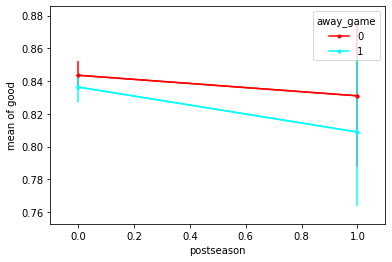

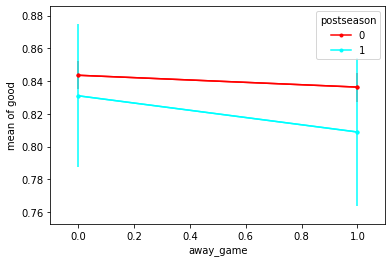

In [29]:
fig = interaction_plot(x=df['postseason'].values,trace=df['away_game'].values,response=df['good'].values, xlabel='postseason', legendtitle='away_game', ylabel='good', errorbars=True)
plt.show()

fig = interaction_plot(x=df['away_game'].values,trace=df['postseason'].values,response=df['good'].values, xlabel='away_game', legendtitle='postseason', ylabel='good', errorbars=True)
plt.show()

In [30]:
print('P(LR|Ho): ',df_inter.loc['postseason*away_game', 'p'])
df_inter.loc['postseason*away_game', 'diff']

P(LR|Ho):  1.0


,coef with_postseason:away_game,coef w/o_postseason:away_game,% coef,se with_postseason:away_game,se w/o_postseason:away_game,% se,P with_postseason:away_game,P w/o_postseason:away_game
Intercept,-94.0437,-94.0453,-0.001701,11.636,11.636,0.000000,0.000,0.000
altitude,0.4842,0.4842,0.000000,0.148,0.148,0.000000,0.001,0.001
away_game,-0.0106,-0.0128,-20.754717,0.050,0.049,2.000000,0.834,0.795
cold,-0.3779,-0.3778,0.026462,0.057,0.057,0.000000,0.000,0.000
dist,-0.1150,-0.1150,-0.000000,0.003,0.003,0.000000,0.000,0.000
iced,-0.1347,-0.1348,-0.074239,0.074,0.074,0.000000,0.067,0.067
postseason,-0.1567,-0.1832,-16.911295,0.176,0.121,31.250000,0.373,0.131
postseason:away_game,-0.0503,NaN,NaN,0.241,NaN,NaN,0.834,NaN
precipitation,-0.1912,-0.1913,-0.052301,0.085,0.084,1.176471,0.024,0.024
pressure,0.0209,0.0210,-0.478469,0.024,0.024,0.000000,0.385,0.382


We're talking about small interaction effects as the error bars kind of consume the difference. It's reasonable to think the added effect of postseason may make an away_game kick more difficult, mentally. The interaction looks weak.

#### Iced & Away games

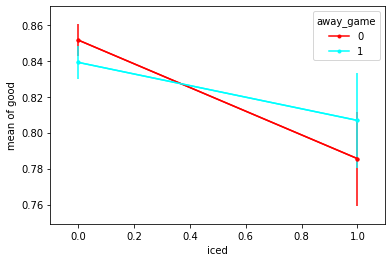

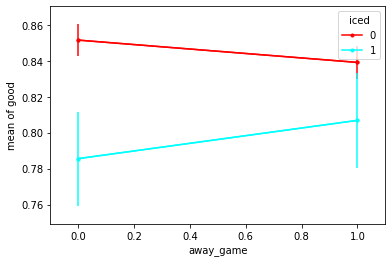

iced  away_game
0     0            6411
      1            6097
1     0             942
      1             849
dtype: int64


In [31]:
fig = interaction_plot(x=df['iced'].values,trace=df['away_game'].values,response=df['good'].values, xlabel='iced', legendtitle='away_game', ylabel='good', errorbars=True)
plt.show()

fig = interaction_plot(x=df['away_game'].values,trace=df['iced'].values,response=df['good'].values, xlabel='away_game', legendtitle='iced', ylabel='good', errorbars=True)
plt.show()

print(df.groupby(['iced', 'away_game']).size())

In [32]:
print('P(LR|Ho): ',df_inter.loc['iced*away_game', 'p'])
df_inter.loc['iced*away_game', 'diff']

P(LR|Ho):  0.05777957112358472


,coef with_iced:away_game,coef w/o_iced:away_game,% coef,se with_iced:away_game,se w/o_iced:away_game,% se,P with_iced:away_game,P w/o_iced:away_game
Intercept,-94.1532,-94.0453,0.114600,11.640,11.636,0.034364,0.000,0.000
altitude,0.4798,0.4842,-0.917049,0.148,0.148,0.000000,0.001,0.001
away_game,-0.0513,-0.0128,75.048733,0.053,0.049,7.547170,0.337,0.795
cold,-0.3773,-0.3778,-0.132521,0.057,0.057,0.000000,0.000,0.000
dist,-0.1150,-0.1150,-0.000000,0.003,0.003,0.000000,0.000,0.000
iced,-0.2595,-0.1348,48.053950,0.098,0.074,24.489796,0.008,0.067
iced:away_game,0.2650,NaN,NaN,0.140,NaN,NaN,0.059,NaN
postseason,-0.1841,-0.1832,0.488865,0.121,0.121,0.000000,0.129,0.131
precipitation,-0.1937,-0.1913,1.239029,0.085,0.084,1.176471,0.022,0.024
pressure,0.0204,0.0210,-2.941176,0.024,0.024,0.000000,0.397,0.382


What about the iced*away_game interaction. Looks like the effect of icing is diminished at an away_game but might be too big of a conclusion to make.

Iced & Cold

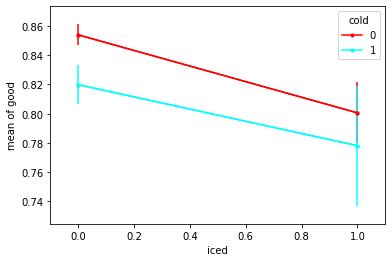

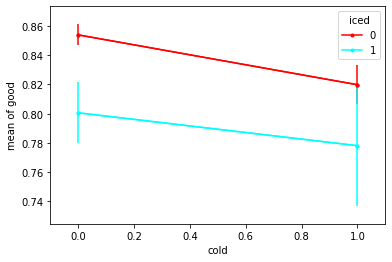

iced  cold
0     0       9383
      1       3125
1     0       1399
      1        392
dtype: int64


In [33]:
fig = interaction_plot(x=df['iced'].values,trace=df['cold'].values,response=df['good'].values, xlabel='iced', legendtitle='cold', ylabel='good', errorbars=True)
plt.show()

fig = interaction_plot(x=df['cold'].values,trace=df['iced'].values,response=df['good'].values, xlabel='cold', legendtitle='iced', ylabel='good', errorbars=True)
plt.show()

print(df.groupby(['iced', 'cold']).size())

In [34]:
print('P(LR|Ho): ',df_inter.loc['iced*cold', 'p'])
df_inter.loc['iced*cold', 'diff']

P(LR|Ho):  0.1213352503583693


,coef with_iced:cold,coef w/o_iced:cold,% coef,se with_iced:cold,se w/o_iced:cold,% se,P with_iced:cold,P w/o_iced:cold
Intercept,-94.5268,-94.0453,0.509379,11.642,11.636,0.051538,0.000,0.000
altitude,0.4842,0.4842,0.000000,0.148,0.148,0.000000,0.001,0.001
away_game,-0.0126,-0.0128,-1.587302,0.049,0.049,0.000000,0.798,0.795
cold,-0.4113,-0.3778,8.144906,0.061,0.057,6.557377,0.000,0.000
dist,-0.1151,-0.1150,0.086881,0.003,0.003,0.000000,0.000,0.000
iced,-0.1971,-0.1348,31.608321,0.083,0.074,10.843373,0.018,0.067
iced:cold,0.2509,NaN,NaN,0.164,NaN,NaN,0.126,NaN
postseason,-0.1822,-0.1832,-0.548847,0.121,0.121,0.000000,0.133,0.131
precipitation,-0.1916,-0.1913,0.156576,0.084,0.084,0.000000,0.023,0.024
pressure,0.0216,0.0210,2.777778,0.024,0.024,0.000000,0.369,0.382


Not the most unlikely interaction but there doesn't seem to be much.

#### Iced & Pressure

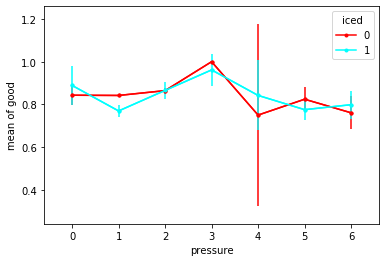

iced  pressure
0     0            242
      1           9560
      2           2407
      3             13
      4              4
      5            165
      6            117
1     0             45
      1            967
      2            305
      3             26
      4             19
      5            285
      6            144
dtype: int64


In [35]:
fig = interaction_plot(x=df['pressure'].values,trace=df['iced'].values,response=df['good'].values, xlabel='pressure', legendtitle='iced', ylabel='good', errorbars=True)
plt.show()

print(df.groupby(['iced', 'pressure']).size())

In [36]:
print('P(LR|Ho): ',df_inter.loc['pressure*iced', 'p'])
df_inter.loc['pressure*iced', 'diff']

P(LR|Ho):  0.43857802608086105


,coef with_pressure:iced,coef w/o_pressure:iced,% coef,se with_pressure:iced,se w/o_pressure:iced,% se,P with_pressure:iced,P w/o_pressure:iced
Intercept,-93.9492,-94.0453,-0.102289,11.637,11.636,0.008593,0.000,0.000
altitude,0.4851,0.4842,0.185529,0.148,0.148,0.000000,0.001,0.001
away_game,-0.0124,-0.0128,-3.225806,0.049,0.049,0.000000,0.801,0.795
cold,-0.3784,-0.3778,0.158562,0.057,0.057,0.000000,0.000,0.000
dist,-0.1151,-0.1150,0.086881,0.003,0.003,0.000000,0.000,0.000
iced,-0.0717,-0.1348,-88.005579,0.113,0.074,34.513274,0.526,0.067
postseason,-0.1838,-0.1832,0.326442,0.121,0.121,0.000000,0.129,0.131
precipitation,-0.1901,-0.1913,-0.631247,0.085,0.084,1.176471,0.024,0.024
pressure,0.0380,0.0210,44.736842,0.033,0.024,27.272727,0.257,0.382
pressure:iced,-0.0355,NaN,NaN,0.048,NaN,NaN,0.462,NaN


Not much pressure data to work with here, which is why the error bars are so wide. We can't say for certain if there is an interaction and the LR test suggests it is a weak predictor. Still seems reasonable to think there would be an interaction.

#### Distance & Wind

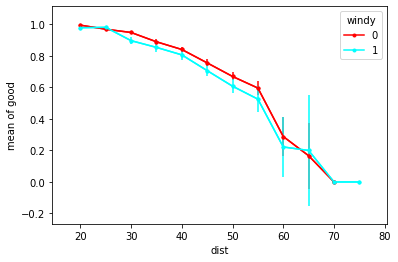

windy  dist
0      20.0     906
       25.0    1397
       30.0    1435
       35.0    1464
       40.0    1599
       45.0    1488
       50.0    1291
       55.0     426
       60.0      52
       65.0      12
       70.0       3
1      20.0     391
       25.0     655
       30.0     603
       35.0     646
       40.0     689
       45.0     638
       50.0     444
       55.0     135
       60.0      18
       65.0       5
       70.0       1
       75.0       1
dtype: int64


In [37]:
# We need to group the distances to make the plots readable.
df_5 = df.copy()
df_5['dist'] = 5*round(df_5['dist']/5)


fig = interaction_plot(x=df_5['dist'].values,trace=df_5['windy'].values,response=df_5['good'].values, xlabel='dist', legendtitle='windy', ylabel='good', errorbars=True)
plt.show()

print(df_5.groupby(['windy', 'dist']).size())

In [38]:
print('P(LR|Ho): ',df_inter.loc['windy*dist', 'p'])
df_inter.loc['windy*dist', 'diff']

P(LR|Ho):  0.6547208460179896


,coef with_windy:dist,coef w/o_windy:dist,% coef,se with_windy:dist,se w/o_windy:dist,% se,P with_windy:dist,P w/o_windy:dist
Intercept,-94.0245,-94.0453,-0.022122,11.636,11.636,0.000000,0.000,0.000
altitude,0.4846,0.4842,0.082542,0.148,0.148,0.000000,0.001,0.001
away_game,-0.0129,-0.0128,0.775194,0.049,0.049,0.000000,0.794,0.795
cold,-0.3773,-0.3778,-0.132521,0.057,0.057,0.000000,0.000,0.000
dist,-0.1159,-0.1150,0.776531,0.004,0.003,25.000000,0.000,0.000
iced,-0.1350,-0.1348,0.148148,0.074,0.074,0.000000,0.066,0.067
postseason,-0.1829,-0.1832,-0.164024,0.121,0.121,0.000000,0.131,0.131
precipitation,-0.1914,-0.1913,0.052247,0.084,0.084,0.000000,0.023,0.024
pressure,0.0213,0.0210,1.408451,0.024,0.024,0.000000,0.377,0.382
seasons,0.0140,0.0140,0.000000,0.005,0.005,0.000000,0.005,0.005


Interestingly enough, pre-2015, the interaction between distance and wind seems negligible. But in the range of 40-60 yards there does seem to be a divergence, above 50 yards there is just not enough data to conclude anything.

#### Iced & Postseason

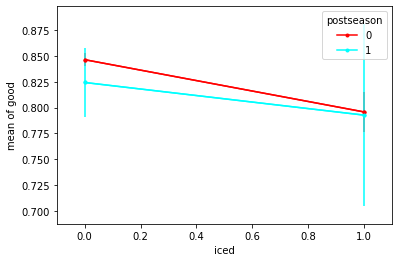

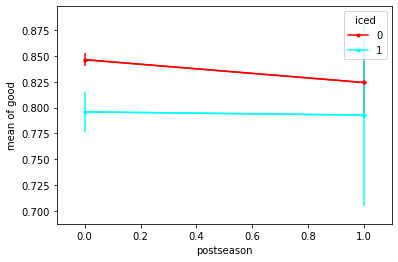

iced  postseason
0     0             0.846333
      1             0.824242
1     0             0.795787
      1             0.792683
Name: good, dtype: float64


In [39]:
fig = interaction_plot(x=df['iced'].values,trace=df['postseason'].values,response=df['good'].values, xlabel='iced', legendtitle='postseason', ylabel='good', errorbars=True)
plt.show()

fig = interaction_plot(x=df['postseason'].values,trace=df['iced'].values,response=df['good'].values, xlabel='postseason', legendtitle='iced', ylabel='good', errorbars=True)
plt.show()

print(df.drop('fkicker', axis=1).groupby(['iced', 'postseason']).aggregate(lambda x: np.mean(x)).loc[:,'good'])

In [40]:
print('P(LR|Ho): ',df_inter.loc['postseason*iced', 'p'])
df_inter.loc['postseason*iced', 'diff']

P(LR|Ho):  1.0


,coef with_postseason:iced,coef w/o_postseason:iced,% coef,se with_postseason:iced,se w/o_postseason:iced,% se,P with_postseason:iced,P w/o_postseason:iced
Intercept,-94.0453,-94.0453,-0.000000,11.636,11.636,0.000000,0.000,0.000
altitude,0.4845,0.4842,0.061920,0.148,0.148,0.000000,0.001,0.001
away_game,-0.0129,-0.0128,0.775194,0.049,0.049,0.000000,0.795,0.795
cold,-0.3776,-0.3778,-0.052966,0.057,0.057,0.000000,0.000,0.000
dist,-0.1150,-0.1150,-0.000000,0.003,0.003,0.000000,0.000,0.000
iced,-0.1378,-0.1348,2.177068,0.075,0.074,1.333333,0.067,0.067
postseason,-0.1931,-0.1832,5.126877,0.132,0.121,8.333333,0.144,0.131
postseason:iced,0.0611,NaN,NaN,0.328,NaN,NaN,0.852,NaN
precipitation,-0.1913,-0.1913,-0.000000,0.085,0.084,1.176471,0.024,0.024
pressure,0.0210,0.0210,0.000000,0.024,0.024,0.000000,0.384,0.382


No clear interaction here.

#### Pressure & Postseason

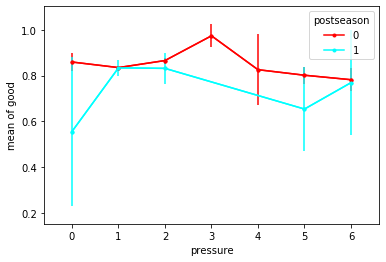

pressure  postseason
0         0             0.859712
          1             0.555556
1         0             0.835328
          1             0.834135
2         0             0.866102
          1             0.831858
3         0             0.974359
4         0             0.826087
5         0             0.801887
          1             0.653846
6         0             0.782258
          1             0.769231
Name: good, dtype: float64


In [41]:
fig = interaction_plot(x=df['pressure'].values,trace=df['postseason'].values,response=df['good'].values, xlabel='pressure', legendtitle='postseason', ylabel='good', errorbars=True)
plt.show()

print(df.drop('fkicker', axis=1).groupby(['pressure', 'postseason']).aggregate(lambda x: np.mean(x)).loc[:,'good'])

In [42]:
print('P(LR|Ho): ',df_inter.loc['pressure*postseason', 'p'])
df_inter.loc['pressure*postseason', 'diff']

P(LR|Ho):  0.37109336952237104


,coef with_pressure:postseason,coef w/o_pressure:postseason,% coef,se with_pressure:postseason,se w/o_pressure:postseason,% se,P with_pressure:postseason,P w/o_pressure:postseason
Intercept,-93.9767,-94.0453,-0.072997,11.637,11.636,0.008593,0.000,0.000
altitude,0.4837,0.4842,-0.103370,0.148,0.148,0.000000,0.001,0.001
away_game,-0.0135,-0.0128,5.185185,0.049,0.049,0.000000,0.784,0.795
cold,-0.3780,-0.3778,0.052910,0.057,0.057,0.000000,0.000,0.000
dist,-0.1150,-0.1150,-0.000000,0.003,0.003,0.000000,0.000,0.000
iced,-0.1348,-0.1348,-0.000000,0.074,0.074,0.000000,0.067,0.067
postseason,-0.0533,-0.1832,-243.714822,0.192,0.121,36.979167,0.782,0.131
precipitation,-0.1907,-0.1913,-0.314630,0.085,0.084,1.176471,0.024,0.024
pressure,0.0260,0.0210,19.230769,0.025,0.024,4.000000,0.294,0.382
pressure:postseason,-0.0838,NaN,NaN,0.095,NaN,NaN,0.378,NaN


The LR test suggests the interaction doesnt help the model and subsequently the p value is insignificant. Probably not much of an interaction here graphically either.

#### Pressure & Distance

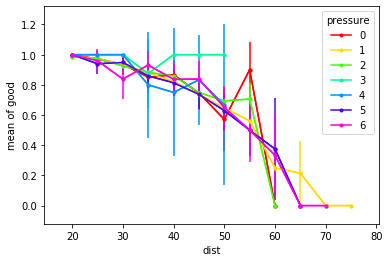

pressure  dist
0         20.0    1.000000
          25.0    0.971429
          30.0    0.936170
          35.0    0.851064
          40.0    0.866667
                    ...   
6         50.0    0.651163
          55.0    0.500000
          60.0    0.333333
          65.0    0.000000
          70.0    0.000000
Name: good, Length: 65, dtype: float64


In [43]:
# Again we need to group distance.
df_5 = df.copy()
df_5['dist'] = 5*round(df_5['dist']/5)

fig = interaction_plot(x=df_5['dist'].values,trace=df_5['pressure'].values,response=df_5['good'].values, xlabel='dist', legendtitle='pressure', ylabel='good', errorbars=True)
plt.show()

print(df_5.drop('fkicker', axis=1).groupby(['pressure', 'dist']).aggregate(lambda x: np.mean(x)).loc[:,'good'])

In [44]:
print('P(LR|Ho): ',df_inter.loc['pressure*dist', 'p'])
df_inter.loc['pressure*dist', 'diff']

P(LR|Ho):  1.0


,coef with_pressure:dist,coef w/o_pressure:dist,% coef,se with_pressure:dist,se w/o_pressure:dist,% se,P with_pressure:dist,P w/o_pressure:dist
Intercept,-94.0126,-94.0453,-0.034783,11.638,11.636,0.017185,0.000,0.000
altitude,0.4840,0.4842,-0.041322,0.148,0.148,0.000000,0.001,0.001
away_game,-0.0128,-0.0128,-0.000000,0.049,0.049,0.000000,0.795,0.795
cold,-0.3778,-0.3778,-0.000000,0.057,0.057,0.000000,0.000,0.000
dist,-0.1156,-0.1150,0.519031,0.005,0.003,40.000000,0.000,0.000
iced,-0.1343,-0.1348,-0.372301,0.074,0.074,0.000000,0.068,0.067
postseason,-0.1832,-0.1832,-0.000000,0.121,0.121,0.000000,0.131,0.131
precipitation,-0.1914,-0.1913,0.052247,0.084,0.084,0.000000,0.024,0.024
pressure,0.0020,0.0210,-950.000000,0.120,0.024,80.000000,0.987,0.382
pressure:dist,0.0004,NaN,NaN,0.003,NaN,NaN,0.871,NaN


Not much going on here. And we just dont have enough pressure data points to work with.

#### Seasons & Distance

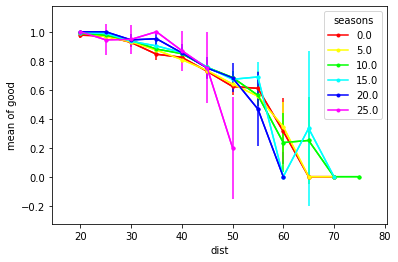

seasons  dist
0.0      20.0    0.976471
         25.0    0.970909
         30.0    0.926471
         35.0    0.844985
         40.0    0.823529
                   ...   
25.0     30.0    0.947368
         35.0    1.000000
         40.0    0.869565
         45.0    0.750000
         50.0    0.200000
Name: good, Length: 61, dtype: float64


In [45]:
# Now we need to group seasons.
df_5['seasons'] = 5*round(df_5['seasons']/5)

fig = interaction_plot(x=df_5['dist'].values,trace=df_5['seasons'].values,response=df_5['good'].values, xlabel='dist', legendtitle='seasons', ylabel='good', errorbars=True)
plt.show()

print(df_5.drop('fkicker', axis=1).groupby(['seasons', 'dist']).aggregate(lambda x: np.mean(x)).loc[:,'good'])

In [46]:
print('P(LR|Ho): ',df_inter.loc['seasons*dist', 'p'])
df_inter.loc['seasons*dist', 'diff']

P(LR|Ho):  0.03197195617764182


,coef with_seasons:dist,coef w/o_seasons:dist,% coef,se with_seasons:dist,se w/o_seasons:dist,% se,P with_seasons:dist,P w/o_seasons:dist
Intercept,-94.4106,-94.0453,0.386927,11.635,11.636,-0.008595,0.000,0.000
altitude,0.4803,0.4842,-0.811993,0.148,0.148,0.000000,0.001,0.001
away_game,-0.0141,-0.0128,9.219858,0.049,0.049,0.000000,0.775,0.795
cold,-0.3772,-0.3778,-0.159067,0.057,0.057,0.000000,0.000,0.000
dist,-0.1052,-0.1150,-9.315589,0.005,0.003,40.000000,0.000,0.000
iced,-0.1366,-0.1348,1.317716,0.074,0.074,0.000000,0.063,0.067
postseason,-0.1815,-0.1832,-0.936639,0.121,0.121,0.000000,0.134,0.131
precipitation,-0.1886,-0.1913,-1.431601,0.084,0.084,0.000000,0.025,0.024
pressure,0.0209,0.0210,-0.478469,0.024,0.024,0.000000,0.385,0.382
seasons,0.0702,0.0140,80.056980,0.027,0.005,81.481481,0.009,0.005


Error bars are too wide here to say much from the interaction plot. But the interaction seems to be plausible. Maybe a slight negative effect for an older kicker at distance.

Precipitation & Distance

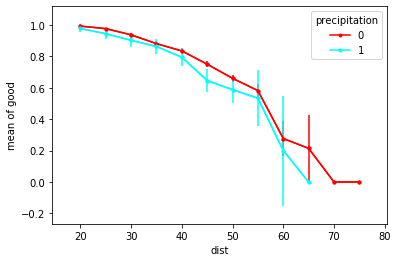

precipitation  dist
0              20.0    0.992275
               25.0    0.976216
               30.0    0.936927
               35.0    0.880705
               40.0    0.834371
               45.0    0.750000
               50.0    0.659987
               55.0    0.581921
               60.0    0.276923
               65.0    0.214286
               70.0    0.000000
               75.0    0.000000
1              20.0    0.977273
               25.0    0.943750
               30.0    0.901639
               35.0    0.862637
               40.0    0.793970
               45.0    0.646067
               50.0    0.586957
               55.0    0.533333
               60.0    0.200000
               65.0    0.000000
Name: good, dtype: float64


In [47]:
fig = interaction_plot(x=df_5['dist'].values,trace=df_5['precipitation'].values,response=df_5['good'].values, xlabel='dist', legendtitle='precipitation', ylabel='good', errorbars=True)
plt.show()

print(df_5.drop('fkicker', axis=1).groupby(['precipitation', 'dist']).aggregate(lambda x: np.mean(x)).loc[:,'good'])


In [48]:
print('P(LR|Ho): ',df_inter.loc['precipitation*dist', 'p'])
df_inter.loc['precipitation*dist', 'diff']

P(LR|Ho):  0.43857802608086105


,coef with_precipitation:dist,coef w/o_precipitation:dist,% coef,se with_precipitation:dist,se w/o_precipitation:dist,% se,P with_precipitation:dist,P w/o_precipitation:dist
Intercept,-94.0875,-94.0453,0.044852,11.638,11.636,0.017185,0.000,0.000
altitude,0.4852,0.4842,0.206101,0.148,0.148,0.000000,0.001,0.001
away_game,-0.0129,-0.0128,0.775194,0.049,0.049,0.000000,0.794,0.795
cold,-0.3774,-0.3778,-0.105988,0.057,0.057,0.000000,0.000,0.000
dist,-0.1157,-0.1150,0.605013,0.003,0.003,0.000000,0.000,0.000
iced,-0.1343,-0.1348,-0.372301,0.074,0.074,0.000000,0.068,0.067
postseason,-0.1828,-0.1832,-0.218818,0.121,0.121,0.000000,0.131,0.131
precipitation,-0.4829,-0.1913,60.385173,0.413,0.084,79.661017,0.242,0.024
precipitation:dist,0.0070,NaN,NaN,0.010,NaN,NaN,0.472,NaN
pressure,0.0208,0.0210,-0.961538,0.024,0.024,0.000000,0.386,0.382


The curves looks to diverge for longer kicks but the LR test failed to reject the null.

#### Seasons & Away

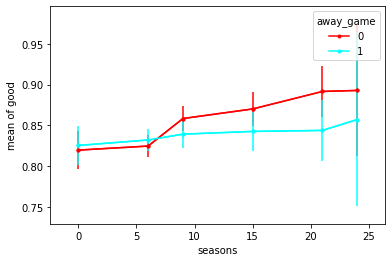

seasons  away_game
0.0      0            0.819578
         1            0.825283
6.0      0            0.824543
         1            0.832006
9.0      0            0.858367
         1            0.839183
15.0     0            0.870130
         1            0.842511
21.0     0            0.891599
         1            0.843750
24.0     0            0.892857
         1            0.857143
Name: good, dtype: float64


In [49]:
df_5['seasons'] = 3*round(df_5['seasons']/3)

fig = interaction_plot(x=df_5['seasons'].values,trace=df_5['away_game'].values,response=df_5['good'].values, xlabel='seasons', legendtitle='away_game', ylabel='good', errorbars=True)
plt.show()

print(df_5.drop('fkicker', axis=1).groupby(['seasons', 'away_game']).aggregate(lambda x: np.mean(x)).loc[:,'good'])

In [50]:
print('P(LR|Ho): ',df_inter.loc['seasons*away_game', 'p'])
df_inter.loc['seasons*away_game', 'diff']

P(LR|Ho):  0.01277503128308216


,coef with_seasons:away_game,coef w/o_seasons:away_game,% coef,se with_seasons:away_game,se w/o_seasons:away_game,% se,P with_seasons:away_game,P w/o_seasons:away_game
Intercept,-94.6409,-94.0453,0.629326,11.645,11.636,0.077286,0.000,0.000
altitude,0.4708,0.4842,-2.846219,0.148,0.148,0.000000,0.001,0.001
away_game,0.1755,-0.0128,107.293447,0.090,0.049,45.555556,0.051,0.795
cold,-0.3725,-0.3778,-1.422819,0.057,0.057,0.000000,0.000,0.000
dist,-0.1150,-0.1150,-0.000000,0.003,0.003,0.000000,0.000,0.000
iced,-0.1332,-0.1348,-1.201201,0.074,0.074,0.000000,0.070,0.067
postseason,-0.1838,-0.1832,0.326442,0.121,0.121,0.000000,0.130,0.131
precipitation,-0.1789,-0.1913,-6.931247,0.085,0.084,1.176471,0.035,0.024
pressure,0.0204,0.0210,-2.941176,0.024,0.024,0.000000,0.397,0.382
seasons,0.0267,0.0140,47.565543,0.007,0.005,28.571429,0.000,0.005


A weird one, almost certainly spurious.

Points:
* It's tough to separate the effect of postseason games and the cold. There's never a postseason game during the warmer months so maybe we'll have to do an observational study for this. My thoughts are its the cold doing the work, because the OVB when leaving out cold is significant on the postseason coefficient but not other way around. But pressure\*postseason makes more sense than pressure\*cold.

* Choose: seasons\*dist, windy\*cold, iced\*away_game, pressure\*postseason, pressure\*iced.

* I wanted to keep wind\*dist but there was no evidence that supported my hypothesis.


From LASSO:
* iced\*away_game
* windy\*cold

From LR:
* seasons\*dist
* pressure\*iced (not sig)
* pressure\*postseason (not sig)

### Form

Lets see if a new feature adds anything. A exponential weighted average of recent form.

In [62]:
# get form feature
df_form = df.copy()
df_form['form'] = df_form.groupby('fkicker')['good'].transform(lambda row: row.ewm(span=10).mean().shift(1))

In [63]:
# base result without form
formula = 'good ~ ' + '+'.join(df_form.drop(['good','fkicker','form'], axis=1).columns.values)
model = glm_sm(formula, df_form.dropna(), family=sm.families.Binomial())
base_result = model.fit(method='irls')
without_ = Summary(base_result)
print(without_.result.summary())

# with form
formula = 'good ~ ' + '+'.join(df_form.drop(['good','fkicker'], axis=1).columns.values) + ''
model = glm_sm(formula, df_form.dropna(), family=sm.families.Binomial())
result = model.fit(method='irls')
with_ = Summary(result)
diff, p = with_ - without_
print(f'P(LR|Ho):{p}\n', f'With interactions:{with_.log_likelihood}\n', f'Without interactions:{without_.log_likelihood}')
print(result.summary())

Generalized Linear Model Regression Results                  
Dep. Variable:                   good   No. Observations:                14133
Model:                            GLM   Df Residuals:                    14120
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5231.2
Date:                Fri, 28 Feb 2020   Deviance:                       10462.
Time:                        08:18:05   Pearson chi2:                 1.33e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -93.0339     11.750     -7.918      0.000    -1

Doesn't seem to be much happening, but its not nothing. Let's check the correlations.

In [64]:
diff

,coef with_form,coef w/o_form,% coef,se with_form,se w/o_form,% se,P with_form,P w/o_form
Intercept,-90.8045,-93.0339,-2.455165,11.855,11.750,0.885702,0.000,0.000
altitude,0.4779,0.4775,0.083700,0.149,0.149,0.000000,0.001,0.001
away_game,-0.0081,-0.0081,-0.000000,0.050,0.050,0.000000,0.870,0.870
cold,-0.3773,-0.3802,-0.768619,0.057,0.057,0.000000,0.000,0.000
dist,-0.1148,-0.1147,0.087108,0.003,0.003,0.000000,0.000,0.000
form,0.2921,NaN,NaN,0.201,NaN,NaN,0.146,NaN
iced,-0.1245,-0.1255,-0.803213,0.074,0.074,0.000000,0.093,0.090
postseason,-0.1870,-0.1843,1.443850,0.121,0.121,0.000000,0.123,0.128
precipitation,-0.1859,-0.1847,0.645508,0.085,0.085,0.000000,0.029,0.030
pressure,0.0196,0.0188,4.081633,0.024,0.024,0.000000,0.417,0.435


No OVB but no multicollinearity so no harm in keeping it. Might be interesting to see how the feature develops with the newer data.

#### Quadratic Seasons

The rate of conversion with seasons seemed to peak mid career and slightly drop off at the end, indicating a non-linear relationship. We try to capture this with a squared seasons term, resulting in a quadratic relationship between 'good' and seasons.

In [65]:
# base result without seasons^2
formula = 'good ~ ' + '+'.join(df.drop(['good','fkicker'], axis=1).columns.values)
model = glm_sm(formula, df, family=sm.families.Binomial())
base_result = model.fit(method='irls')
without_ = Summary(base_result)
print(without_.result.summary())

# result with seasons^2
formula = 'good ~ ' + '+'.join(df.drop(['good','fkicker'], axis=1).columns.values) + '+ seasons^2'
model = glm_sm(formula, df, family=sm.families.Binomial())
result = model.fit(method='irls')
with_ = Summary(result)
diff, p = with_ - without_
print(f'P(LR|Ho):{p}\n', f'With quad:{with_.log_likelihood}\n', f'Without quad:{without_.log_likelihood}')
print(result.summary())

Generalized Linear Model Regression Results                  
Dep. Variable:                   good   No. Observations:                14213
Model:                            GLM   Df Residuals:                    14199
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5258.5
Date:                Fri, 28 Feb 2020   Deviance:                       10517.
Time:                        08:18:31   Pearson chi2:                 1.34e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -89.7172     11.813     -7.595      0.000    -1

Didn't really help at all, possibly because the seasons variables has weak influence on 'good' anyway.

In [ ]:
diff

### Modelling

We now add in the interactions and form variables and train a model using data pre-2015 data.

In [367]:
where = '''and (
(
    fg.fkicker in (select fkicker from fifty) -- has had at least 50 attempts overall (this keeps only kickers that would end up making it in the NFL)
) or    
(
    k.seas>=3  -- or they had played 3 seasons up to the kick (stops removal of kicks from experienced kickers' kicks from early or late in the dataset)
)
)'''

In [368]:
df = get_data(cnx, date_condition='< 2015', where=where, base='six_cat').drop('humid', axis=1)

In [389]:
df['form'] = df.groupby('fkicker')['good'].transform(lambda row: row.ewm(span=10).mean().shift(1))
df = df.dropna()
# interactions = '+ cold*windy + seasons*dist + iced*away_game + pressure*iced + pressure*postseason'
interactions = '+ cold*windy + seasons*dist + iced*away_game + pressure*iced + pressure*postseason'
quad = ''

In [390]:
df_test = df.sample(frac=0.1)
df_train = df.drop(df_test.index)

print('Train: ', df_test['good'].value_counts(normalize=True)[1])
print('Test: ', df_train['good'].value_counts(normalize=True)[1])

Train:  0.8372257607926398
Test:  0.8400157232704403


In [391]:
# base result without interactions
formula = 'good ~ ' + '+'.join(df_train.drop(['good','fkicker','form'], axis=1).columns.values)
model = glm_sm(formula, df_train, family=sm.families.Binomial())
base_result = model.fit(method='irls')
without_ = Summary(base_result)
print(without_.result.summary())

Generalized Linear Model Regression Results                  
Dep. Variable:                   good   No. Observations:                12720
Model:                            GLM   Df Residuals:                    12707
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4719.4
Date:                Fri, 28 Feb 2020   Deviance:                       9438.8
Time:                        13:44:33   Pearson chi2:                 1.20e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -94.5215     12.352     -7.652      0.000    -1

In [392]:
formula = 'good ~ ' + '+'.join(df_train.drop(['good','fkicker'], axis=1).columns.values) + interactions + quad
model = glm_sm(formula, df_train, family=sm.families.Binomial())
result = model.fit(method='irls')
with_ = Summary(result)
diff, p = with_ - without_
print(f'P(LR|Ho):{p}\n', f'With interactions:{with_.log_likelihood}\n', f'Without interactions:{without_.log_likelihood}')

P(LR|Ho):0.06196880441665898
 With interactions:-4713.4
 Without interactions:-4719.4


In [393]:
print(with_.result.summary())

Generalized Linear Model Regression Results                  
Dep. Variable:                   good   No. Observations:                12720
Model:                            GLM   Df Residuals:                    12701
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4713.4
Date:                Fri, 28 Feb 2020   Deviance:                       9426.8
Time:                        13:44:35   Pearson chi2:                 1.20e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -92.3734     12.464     -7.41

### Evaluation

In [387]:
from util.evaluation import odds, confusion

In [388]:
sig_coefs = with_.summary['coef'].drop(['windy','pressure','form'])

confusion(['away_game', 'iced'], sig_coefs)
confusion(['cold', 'windy'], sig_coefs)
confusion(['seasons','dist'], sig_coefs)

NameError: name 'np' is not defined

In [ ]:
# odds(**{'seasons':15, 'dist':55})/odds(**{'seasons':0, 'dist':55})
# odds(**{'seasons':15})/odds(**{'seasons':0})
# odds(**{'away_game':0, 'iced':1, 'pressure':6})/odds(**{'away_game':0, 'iced':0, 'pressure':6})
# # odds(**{'pressure':1, 'iced':1})/odds(**{'pressure':1, 'iced':0})
# # odds(**{'pressure':6, 'iced':1})/odds(**{'pressure':6, 'iced':0})

# odds(**{'seasons':1, 'dist':50})/odds(**{'seasons':1, 'dist':49})
# odds(**{'away_game':1, 'iced':0, 'pressure':6})/odds(**{'away_game':0, 'iced':0, 'pressure':6})

We can give some examples of influence.


* Icing an away game kick increases the odds 1.07 times. Weird.
* Icing a home kick, odds are 0.75 times.

* Un-iced, an away kick, odds are 0.91 times.
* Iced, an away kick, odds are 



* For a rookie, every yard added the odds are about 0.9 times.
* However for a veteran of 15 seasons, its gets a bit complicated. Experience matters, but so does the body.
* Over the rookie, at 35 yards (the average kick), the veteran is about 1.5 times more likely to make the kick. If we dont account for distance interacting with the kickers weary old age, this blows out to 3.1 times as likely to convert.
* At 55 yards, a rookie would narrowly pip an experienced 15 season veteran, with the odds ratio dropping to 0.91. Again, not taking the interaction into consideration and "father time" blows out to 3.4 times as likely.


We'll use these values in the next study, which is a Bayesian approach to post-2015 data.

In [394]:
now = dt.now().strftime('%d%m%y')
with_.summary.to_csv(f'fg_results_{now}.csv')

Even though we are interested in accurate inference, let's check the model isn't complete garbage.

In [381]:
from sklearn.metrics import roc_auc_score, roc_curve

In [382]:
y_t = df_test['good']

# base
y_p = base_result.predict(df_test.drop('good',axis=1))
auc_base = roc_auc_score(y_t, y_p)
curve_base = roc_curve(y_t, y_p)
df_base = pd.DataFrame.from_records(np.column_stack(curve_base), columns=['fpr','tpr','thresholds'])
df_base['type'] = 'base'

# interactions
y_p = result.predict(df_test.drop('good',axis=1))
auc = roc_auc_score(y_t, y_p)
curve = roc_curve(y_t, y_p)
df_int = pd.DataFrame.from_records(np.column_stack(curve), columns=['fpr','tpr','thresholds'])
df_int['type'] = 'interactions'

# dummy - good
y_p = [1]*len(df_test)
y_p = pd.Series(y_p)
auc_dg = roc_auc_score(y_t, y_p)
curve_dg = roc_curve(y_t, y_p)
df_dg = pd.DataFrame.from_records(np.column_stack(curve_dg), columns=['fpr','tpr','thresholds'])
df_dg['type'] = 'All good'

# dummy - random @ P(good)
p = df_train['good'].value_counts(normalize=True)[1]
y_p = pd.Series([1 if p>np.random.rand() else 0 for _ in range(len(df_test))])
auc_dp = roc_auc_score(y_t, y_p)
curve_dp = roc_curve(y_t, y_p)
df_dp = pd.DataFrame.from_records(np.column_stack(curve_dp), columns=['fpr','tpr','thresholds'])
df_dp['type'] = 'P(good)'

# dummy - @ dist>40
y_p = df_test['dist']>40
auc_dd = roc_auc_score(y_t, y_p)
curve_dd = roc_curve(y_t, y_p)
df_dd = pd.DataFrame.from_records(np.column_stack(curve_dd), columns=['fpr','tpr','thresholds'])
df_dd['type'] = '@d>40'

In [383]:
aucs = pd.Series([auc_dp, auc_dg, auc_base, auc], index=['@p','good','base','with interactions'])
aucs

@p                   0.496893
good                 0.500000
base                 0.768877
with interactions    0.767791
dtype: float64

Text(0.5, 1.0, 'ROC for each model')

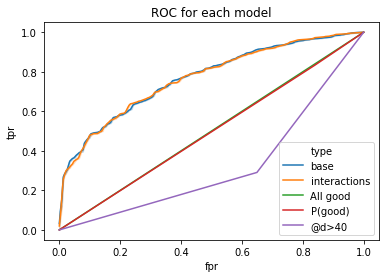

In [384]:
from seaborn import lineplot
df_all = pd.concat([df_base,df_int,df_dg,df_dp,df_dd])
ax = lineplot(x='fpr',y='tpr', data=df_all, hue='type')
ax.set_title('ROC for each model')

Interactions and base model have the same predictive power, but I'd argue the interactions provide more accuracte inference. Both are better than the simplest models.

### See you in the next notebook.